In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hindi-text-short-summarization-corpus/train.csv
/kaggle/input/hindi-text-short-summarization-corpus/test.csv


In [2]:
import pandas as pd
import torch
import random

import numpy as np

In [3]:
train = pd.read_csv("/kaggle/input/hindi-text-short-summarization-corpus/train.csv")
train.head()

,headline,article
0,EXCLUSIVE: दिल्ली में डीजल टैक्सियों पर बैन से...,दिल्ली में सुप्रीम कोर्ट के डीज़ल टैक्सियों को...
1,जॉर्डन: राष्ट्रपति मुखर्जी ने 86 करोड़ डॉलर के...,जॉर्डन के ऐतिहासिक दौरे पर पहुंचे राष्ट्रपति प...
2,UN में पाकिस्तान की राजदूत मलीहा लोधी ने कराई ...,पाकिस्तानी नेताओं को विवादित और हास्यास्पद बया...
3,38 देशों में पीएम नरेंद्र मोदी बायोपिक को रिली...,पीएम नरेंद्र मोदी बायोपिक में विवेक ओबेरॉय ने ...
4,13 अगस्त 2011: दिनभर की बड़ी खबरें पढ़ें,"देश, दुनिया, महानगर, खेल, आर्थिक और बॉलीवुड मे..."


In [4]:
print(train.head(1)["headline"])

0    EXCLUSIVE: दिल्ली में डीजल टैक्सियों पर बैन से...
Name: headline, dtype: object


In [5]:
train.shape

(266607, 2)

In [6]:
test = pd.read_csv("/kaggle/input/hindi-text-short-summarization-corpus/test.csv")
test.shape

(66653, 2)

In [7]:
test.head(5)

,headline,article
0,"पठानकोट पहुंचे PM मोदी, एयरबेस का जायजा ले बॉर...",प्रधानमंत्री नरेंद्र मोदी पठानकोट एयरबेस पहुंच...
1,सचिन ने देशवासियों को समर्पित किया अपना दोहरा शतक,सचिन तेंदुलकर ने एकदिवसीय अंतरराष्ट्रीय क्रिके...
2,एनआईए करेगी छत्तीसगढ़ में सुरक्षा खामियों की ज...,केंद्रीय गृह राज्य मंत्री आर. पी. एन. सिंह ने ...
3,सीधी बात: शाह बोले- हमारा बस चलता तो अब तक मं...,भारतीय जनता पार्टी (बीजेपी) के राष्ट्रीय अध्यक...
4,"ऋषभ पंत के पास यूनिक टैलेंट, उसके साथ छेड़छाड़ न...",ऋषभ पंत की कभी कभार इस बात के लिए आलोचना की जा...


In [8]:
test["headline"][25]

'यूपी के लाल हैं कोविंद, दलित विरोधी हैं मायावतीः केशव मौर्या'

In [9]:
news = pd.concat([train, test], ignore_index=True, sort=False)

In [10]:
news.shape

(333260, 2)

In [11]:
import re
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, ' ', data)

def preprocess_tokenize(text):
      # for removing punctuation from sentencesc
    text = str(text)
    text = re.sub(r'(\d+)', r'', text)
    
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    text = text.replace('\u200d', '')
    text=re.sub("(__+)", ' ', str(text)).lower()   #remove _ if it occors more than one time consecutively
    text=re.sub("(--+)", ' ', str(text)).lower()   #remove - if it occors more than one time consecutively
    text=re.sub("(~~+)", ' ', str(text)).lower()   #remove ~ if it occors more than one time consecutively
    text=re.sub("(\+\++)", ' ', str(text)).lower()   #remove + if it occors more than one time consecutively
    text=re.sub("(\.\.+)", ' ', str(text)).lower()   #remove . if it occors more than one time consecutively
    text=re.sub(r"[<>()|&©@#ø\[\]\'\",;:?.~*!]", ' ', str(text)).lower() #remove <>()|&©ø"',;?~*!
    text = re.sub(r"[‘’।:]", " ", str(text)) #removing other special characters
    text = re.sub("([a-zA-Z])",' ',str(text)).lower()
    text = re.sub("(\s+)",' ',str(text)).lower()
    text = remove_emojis(text)
    return text

In [12]:
train_data_trg = news['headline']
train_data_src = news['article']

In [13]:
tokenized_corpus_trg = [preprocess_tokenize(x) for x in train_data_trg]  #these are headlines
tokenized_corpus_src = [preprocess_tokenize(x) for x in train_data_src]  #these are articles

In [14]:
tokenized_corpus_src[1] #cleaned sentences

'जॉर्डन के ऐतिहासिक दौरे पर पहुंचे राष्ट्रपति प्रणब मुखर्जी ने करोड़ डॉलर की लागत से निर्मित भारत-जॉर्डन उवर्रक संयंत्र का जॉर्डन के शाह अब्दुल्ला द्वितीय इब्न अल हुसैन के साथ उद्घाटन किया यह संयंत्र एक साल से कम समय में बनकर तैयार हुआ है राष्ट्रपति मुखर्जी के यहां एयर इंडिया की उड़ान से दोपहर पहुंचने के कुछ देर बाद ही शाह के महल से इस संयंत्र का रिमोट के जरिए उद्घाटन किया गया अधिकारियों ने बताया कि भारतीय उर्वरक कंपनी इफको और जॉर्डन के फास्फेट्स माइन कंपनी ने इस संयंत्र के लिए में एक संयुक्त उद्यम कंपनी जॉर्डन इंडिया फर्टिलाइजर कंपनी बनाया संयुक्त उद्यम में इफको की हिस्सेदारी प्रतिशत है इस संयंत्र से प्रति वर्ष करोड़ टन सल्फ्यूरिक एसिड और करोड़ टन फास्फेरिक एसिड के उत्पादन का अनुमान है राष्ट्रपति का इससे पहले यहां पारंपरिक स्वागत किया गया और राष्ट्रपति भवन के सामने उन्हें तोपों की सलामी दी गई इसके बाद वह शाह अब्दुल्ला द्वितीय इब्न अल हुसैन के साथ वार्ता में व्यस्त हो गए वार्ता के बाद दोनों नेताओं ने इंडो-जर्मन उवर्रक संयंत्र का संयुक्त रूप से उद्घाटन किया इस संयंत्र से कच्चे माल का उत

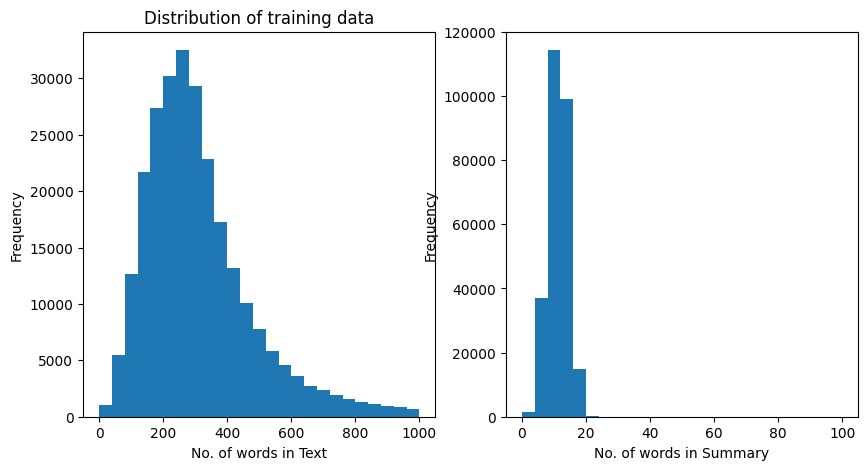

In [15]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in tokenized_corpus_src[:train.shape[0]]:
      text_word_count.append(len(i.split()))

for i in tokenized_corpus_trg[:train.shape[0]]:
      summary_word_count.append(len(i.split()))

fig , ax = plt.subplots(1,2)
fig.set_size_inches(10,5)
ax[0].hist(text_word_count, bins=25, range=[0, 1000])
ax[1].hist(summary_word_count, bins=25, range=[0, 100])
ax[0].set_xlabel("No. of words in Text")
ax[0].set_ylabel("Frequency")
ax[1].set_xlabel("No. of words in Summary")
ax[1].set_ylabel("Frequency")
ax[0].set_title('Distribution of training data')
plt.show()

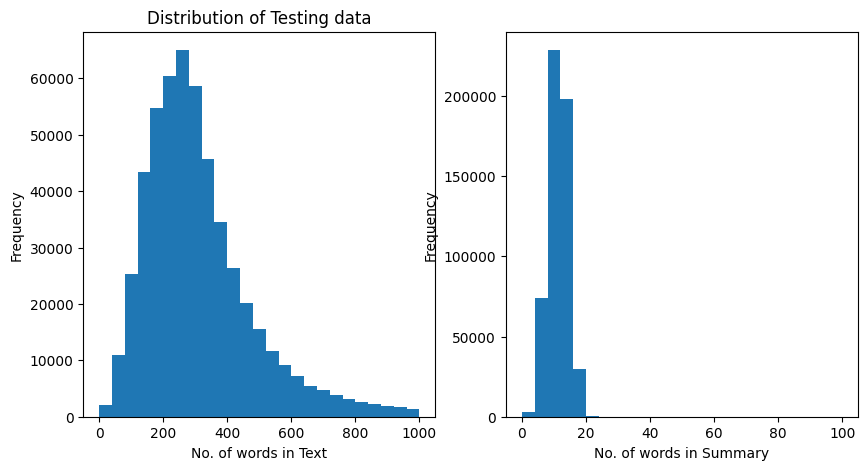

In [16]:
for i in tokenized_corpus_src[:-test.shape[0]]:
      text_word_count.append(len(i.split()))

for i in tokenized_corpus_trg[:-test.shape[0]]:
      summary_word_count.append(len(i.split()))

fig , ax = plt.subplots(1,2)
fig.set_size_inches(10,5)
ax[0].hist(text_word_count, bins=25, range=[0, 1000])
ax[1].hist(summary_word_count, bins=25, range=[0, 100])
ax[0].set_xlabel("No. of words in Text")
ax[0].set_ylabel("Frequency")
ax[1].set_xlabel("No. of words in Summary")
ax[1].set_ylabel("Frequency")
ax[0].set_title('Distribution of Testing data')
plt.show()

In [17]:
news['Text_Cleaned'] = tokenized_corpus_src  
print("::::: Text_Cleaned :::::")
print(news['Text_Cleaned'][0:5], "\n")


news['Summary_Cleaned'] =  tokenized_corpus_trg 
print("::::: Summary :::::")
print(news['Summary_Cleaned'][0:5], "\n")

corpus = list(news['Text_Cleaned'])

::::: Text_Cleaned :::::
0    दिल्ली में सुप्रीम कोर्ट के डीज़ल टैक्सियों को...
1    जॉर्डन के ऐतिहासिक दौरे पर पहुंचे राष्ट्रपति प...
2    पाकिस्तानी नेताओं को विवादित और हास्यास्पद बया...
3    पीएम नरेंद्र मोदी बायोपिक में विवेक ओबेरॉय ने ...
4    देश दुनिया महानगर खेल आर्थिक और बॉलीवुड में क्...
Name: Text_Cleaned, dtype: object 

::::: Summary :::::
0     दिल्ली में डीजल टैक्सियों पर बैन से मुश्किल म...
1    जॉर्डन राष्ट्रपति मुखर्जी ने करोड़ डॉलर के संय...
2     में पाकिस्तान की राजदूत मलीहा लोधी ने कराई फज...
3     देशों में पीएम नरेंद्र मोदी बायोपिक को रिलीज ...
4                      अगस्त दिनभर की बड़ी खबरें पढ़ें
Name: Summary_Cleaned, dtype: object 



In [18]:
text_count = []
summary_count = []

for sent in news['Text_Cleaned']:
    text_count.append(len(sent.split()))
for sent in news['Summary_Cleaned']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame()
graph_df['text'] = text_count
graph_df['summary'] = summary_count

In [19]:
graph_df['text'].describe()

count    333260.000000
mean        348.910493
std         314.028859
min           0.000000
25%         197.000000
50%         282.000000
75%         399.000000
max       15089.000000
Name: text, dtype: float64

In [20]:
graph_df['summary'].describe()

count    333260.000000
mean         10.842576
std           3.001873
min           0.000000
25%           9.000000
50%          11.000000
75%          13.000000
max         162.000000
Name: summary, dtype: float64

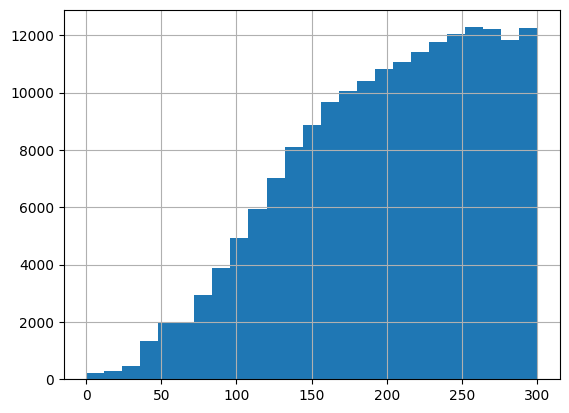

In [21]:
graph_df['text'].hist(bins = 25, range=(0, 300))
plt.show()

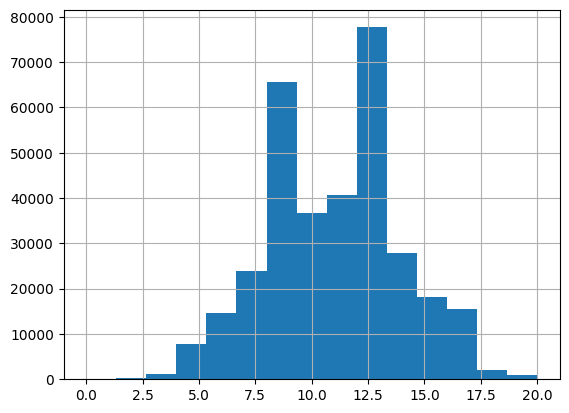

In [22]:
graph_df['summary'].hist(bins = 15, range=(0, 20))
plt.show()

In [23]:
count = 0
for i in graph_df['text']:
    if i > 10 and i <= 300:
        count = count + 1
print(count / len(graph_df['text']))

0.5509842165276361


In [24]:
count = 0
for i in graph_df['summary']:
    if i > 1 and i <= 20:
        count = count + 1
print(count / len(graph_df['summary']))

0.9994118706115346


In [25]:
max_text_len = 300
max_summary_len = 16

In [26]:
cleaned_text = np.array(news['Text_Cleaned'])
cleaned_summary = np.array(news['Summary_Cleaned'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split()) <= max_summary_len 
       and len(cleaned_summary[i].split()) > 1 
       and len(cleaned_text[i].split()) <= max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
    elif((len(cleaned_summary[i].split()) > max_summary_len) or (len(cleaned_text[i].split()) > max_text_len)):
        summ = cleaned_summary[i].split()
        txt = cleaned_text[i].split()
        if(len(summ)>max_summary_len):
          short_summary.append(' '.join(summ[:max_summary_len]))
        else:
          short_summary.append(cleaned_summary[i])
        if(len(txt)>max_text_len):
          short_text.append(' '.join(txt[:max_text_len]))
        else:
          short_text.append(cleaned_text[i]) 
    
post_pre = pd.DataFrame({'text':short_text,'summary':short_summary})

In [27]:
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
post_pre['text'] = post_pre['text'].apply(lambda x: 'sostok ' + x + ' eostok')

In [28]:
post_pre.shape

(333143, 2)

In [29]:
cleaned_summary = np.array(post_pre['summary'])
cleaned_text = np.array(post_pre['text'])
print("cleaned text's size ",cleaned_text.shape)
print("cleaned summary's size ",cleaned_summary.shape)

cleaned text's size  (333143,)
cleaned summary's size  (333143,)


In [30]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [31]:
#Tokenize text to get the vocab count
#prepare a tokenizer for training data
text_tokenizer = Tokenizer() 
text_tokenizer.fit_on_texts(list(cleaned_text))

#prepare a tokenizer for reviews on training data
summary_tokenizer = Tokenizer()   
summary_tokenizer.fit_on_texts(list(cleaned_summary))

In [32]:
vocab = text_tokenizer.word_index
import random
def sample_from_dict(d, sample=10):
    keys = random.sample(list(d), sample)
    values = [d[k] for k in keys]
    return dict(zip(keys, values))

print(sample_from_dict(vocab))

{'पिरवार': 134988, 'उद्धघाटन': 41518, 'डबखेरा': 286248, 'टिप्प्णियां': 352025, 'थीनिया': 175388, 'एतो': 256613, 'भिड़त': 39100, 'एलाइफ': 121226, 'नखवाल': 96914, 'नरेंद्रासन': 142353}


In [33]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in text_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 68.68167602630879
Total Coverage of rare words: 0.41351097036187695


In [34]:
# #prepare a tokenizer for reviews on training data
text_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
text_tokenizer.fit_on_texts(list(cleaned_text))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
text__seq    =   text_tokenizer.texts_to_sequences(cleaned_text)
#padding zero upto maximum length
cleaned_text    =   pad_sequences(text__seq,  maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
text_voc   =  text_tokenizer.num_words + 1

print("Size of vocabulary in text = {}".format(text_voc))

Size of vocabulary in text = 110757


In [35]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in summary_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 58.05363524028988
Total Coverage of rare words: 1.1603857371100994


In [36]:
#prepare a tokenizer for reviews on training data
summary_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
summary_tokenizer.fit_on_texts(list(cleaned_summary))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
summary__seq    =   summary_tokenizer.texts_to_sequences(cleaned_summary)
#padding zero upto maximum length
cleaned_summary    =   pad_sequences(summary__seq,  maxlen=max_summary_len, padding='post')

#size of vocabulary ( +1 for padding token)
summary_voc   =  summary_tokenizer.num_words + 1

print("Size of vocabulary in summary = {}".format(summary_voc))

Size of vocabulary in summary = 25121


In [37]:
summary_tokenizer.word_counts['sostok'],len(cleaned_summary)

(333143, 333143)

In [38]:
default_path = '/kaggle/working/'

In [39]:
import pickle

with open(default_path+'text_tokenizer.pickle', 'wb') as handle:
    pickle.dump(text_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(default_path+'summary_tokenizer.pickle', 'wb') as handle:
    pickle.dump(summary_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
ind=[]
for i in range(len(cleaned_summary)):
    cnt=0
    for j in cleaned_summary[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

cleaned_text = np.delete(cleaned_text, ind, axis=0)
cleaned_summary = np.delete(cleaned_summary, ind, axis=0)

In [41]:
print("cleaned text's size ",cleaned_text.shape)
print("cleaned summary's size ",cleaned_summary.shape)

cleaned text's size  (333130, 300)
cleaned summary's size  (333130, 16)


In [42]:
cleaned_text

array([[   24,    56,     2, ...,     0,     0,     0],
       [11094,     1,  1708, ...,   162,  3278,    25],
       [   24,   580,   333, ...,     0,     0,     0],
       ...,
       [    6,   580,   665, ..., 18583,     8,    25],
       [   24,  2442,  1083, ...,     0,     0,     0],
       [   24,   310,     1, ...,     0,     0,     0]], dtype=int32)

In [43]:
cleaned_summary

array([[    1,    21,     3, ...,     2,     0,     0],
       [    1,  9770,   206, ...,     0,     0,     0],
       [    1,     3,    68, ...,     2,     0,     0],
       ...,
       [    1,    68,     9, ...,     0,     0,     0],
       [   94,    23,    12, ..., 17783, 11079,     2],
       [    1,     4,    26, ...,     2,     0,     0]], dtype=int32)

In [44]:
with open(default_path+'cleaned_text.pickle', 'wb') as handle:
    pickle.dump(cleaned_text, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(default_path+'cleaned_summary.pickle', 'wb') as handle:
    pickle.dump(cleaned_summary, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [45]:
!pip install fasttext

In [46]:
import fasttext.util

In [47]:
fasttext.util.download_model('hi', if_exists='ignore')  # Hindi

 (100.00%) [==================================================>]


'cc.hi.300.bin'

In [48]:
ft = fasttext.load_model(default_path+'cc.hi.300.bin')

In [49]:
word = "नृत्य"
print("Embedding vector shape is {}".format(ft.get_word_vector(word).shape[0]))

Embedding vector shape is 300


In [50]:
def create_weight_matrix(model, DICT_SIZE, tokenizer):
  '''
  Accepts word embedding model
  and the second model, if provided
  Returns weight matrix of size m*n, where
  m - size of the dictionary
  n - size of the word embedding vector

  '''
  vector_size = model.get_word_vector("नृत्य").shape[0]
  w_matrix = np.zeros((DICT_SIZE, vector_size))
  unk_words = []
  text_words = []
  for word, index in tokenizer.word_index.items():
    if index < DICT_SIZE:
      if word in model.words: 
        w_matrix[index] = model.get_word_vector(word)
        text_words.append(word)
      else:
        w_matrix[index] = np.random.rand(1, vector_size)
        unk_words.append(word)
        
  
  print('{} words were considered as they were found in embedding space:'.format(len(text_words)))
  print('{} are some such words'.format(text_words[:10]))
  print()  
  print('{} words were randomly alloted as they were not found in embedding space:'.format(len(unk_words)))
  print('{} are some such words'.format(unk_words[:10]))

  return w_matrix

In [51]:
text_matrix = create_weight_matrix(ft, text_voc, text_tokenizer)

101084 words were considered as they were found in embedding space:
['के', 'में', 'है', 'की', 'को', 'ने', 'से', 'और', 'का', 'पर'] are some such words

9672 words were randomly alloted as they were not found in embedding space:
['sostok', 'eostok', 'सिंबा', 'जेजेपी', 'एयरस्ट्राइक', 'रियलमी', 'इनपुटः', 'मीटू', 'एनालिटिका', 'आर्काइव्ड'] are some such words


In [52]:
summ_matrix = create_weight_matrix(ft, summary_voc, summary_tokenizer)

24917 words were considered as they were found in embedding space:
['में', 'के', 'की', 'का', 'ने', 'से', 'को', 'पर', 'है', 'नहीं'] are some such words

203 words were randomly alloted as they were not found in embedding space:
['sostok', 'eostok', 'एयरस्ट्राइक', 'दीपवीर', 'सिंबा', 'फरीदाबादः', 'रसूखदारः', 'ओडिशाः', 'मिजाजः', 'तेलंगानाः'] are some such words


In [53]:
with open(default_path+'text_matrix.pickle', 'wb') as handle:
    pickle.dump(text_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(default_path+'summ_matrix.pickle', 'wb') as handle:
    pickle.dump(summ_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [54]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import time
import re
import pickle
import matplotlib.pyplot as plt

In [55]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [56]:
with open(default_path+'cleaned_text.pickle', 'rb') as handle:
    cleaned_text = pickle.load(handle)
with open(default_path+'cleaned_summary.pickle', 'rb') as handle:
    cleaned_summary = pickle.load(handle)

In [57]:
cleaned_text.shape

(333130, 300)

In [58]:
x_train, y_train = cleaned_text[:cleaned_text.shape[0]-test.shape[0], :], cleaned_summary[:cleaned_summary.shape[0]-test.shape[0], :]
x_test, y_test = cleaned_text[:-test.shape[0], :], cleaned_summary[:-test.shape[0], :]
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [59]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

In [60]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [61]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [62]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [63]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights

In [64]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [65]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [66]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [67]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, emb_matrix, max_len, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_dim = input_vocab_size, 
                      output_dim = d_model,
                      input_length = max_len, # max_len of text sequence - 300
                      weights=[emb_matrix],
                      trainable=False) # static weights to be assigned from pretrained embedding
        #self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x

In [68]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, emb_matrix, max_len, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        #self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.embedding = tf.keras.layers.Embedding(input_dim = target_vocab_size, 
                      output_dim = d_model,
                      input_length = max_len, # max_len of summ sequence - 16
                      weights=[emb_matrix],
                      trainable=False)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights

In [69]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, text_matrix, max_len_text, summ_matrix, max_len_summ, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, text_matrix, max_len_text, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, summ_matrix, max_len_summ, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [70]:
with open(default_path+'text_matrix.pickle', 'rb') as handle:
    text_matrix = pickle.load(handle)
with open(default_path+'summ_matrix.pickle', 'rb') as handle:
    summ_matrix = pickle.load(handle)

In [71]:
# hyper-params
num_layers = 4
d_model = text_matrix.shape[1]
dff = 512
num_heads = 10
EPOCHS = 10
max_len_text = 300
max_len_summ = 16

In [72]:
encoder_vocab_size = 110757
decoder_vocab_size = 25121

In [73]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [74]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.cast(tf.math.rsqrt(tf.cast(step, tf.float32)), tf.float32)
        arg2 = tf.cast(step, tf.float32) * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [75]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [76]:
val_loss = tf.keras.metrics.Mean(name='val_loss')

In [77]:
transformer = Transformer(
    num_layers, 
    d_model, 
    num_heads, 
    dff,
    encoder_vocab_size, 
    decoder_vocab_size, 
    pe_input = encoder_vocab_size, 
    pe_target = decoder_vocab_size,
    text_matrix = text_matrix, 
    max_len_text = max_len_text, 
    summ_matrix = summ_matrix, 
    max_len_summ = max_len_summ
)

In [78]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [79]:
checkpoint_path = default_path+"checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [80]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)
        
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)

In [81]:
@tf.function
def val_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            False, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)
    val_loss(loss)

Epoch 1 ========> Batch 0 Loss 10.1359
Epoch 1 ========> Batch 2601 Loss 6.4889
Epoch 1/10 ========> Training Loss 6.0228 Test/Validation Loss 4.9520
Time taken for epoch 1: 2139.78 secs

Epoch 2 ========> Batch 0 Loss 5.2897
Epoch 2 ========> Batch 2601 Loss 4.9086
Saving checkpoint for epoch 2 at /kaggle/working/checkpoints/ckpt-1
Epoch 2/10 ========> Training Loss 4.8231 Test/Validation Loss 4.5020
Time taken for epoch 2: 2091.40 secs

Epoch 3 ========> Batch 0 Loss 4.6735
Epoch 3 ========> Batch 2601 Loss 4.5449
Epoch 3/10 ========> Training Loss 4.5071 Test/Validation Loss 4.3217
Time taken for epoch 3: 2090.42 secs

Epoch 4 ========> Batch 0 Loss 4.1951
Epoch 4 ========> Batch 2601 Loss 4.3672
Saving checkpoint for epoch 4 at /kaggle/working/checkpoints/ckpt-2
Epoch 4/10 ========> Training Loss 4.3417 Test/Validation Loss 4.2310
Time taken for epoch 4: 2091.75 secs

Epoch 5 ========> Batch 0 Loss 4.3620
Epoch 5 ========> Batch 2601 Loss 4.2525
Epoch 5/10 ========> Training Loss 4

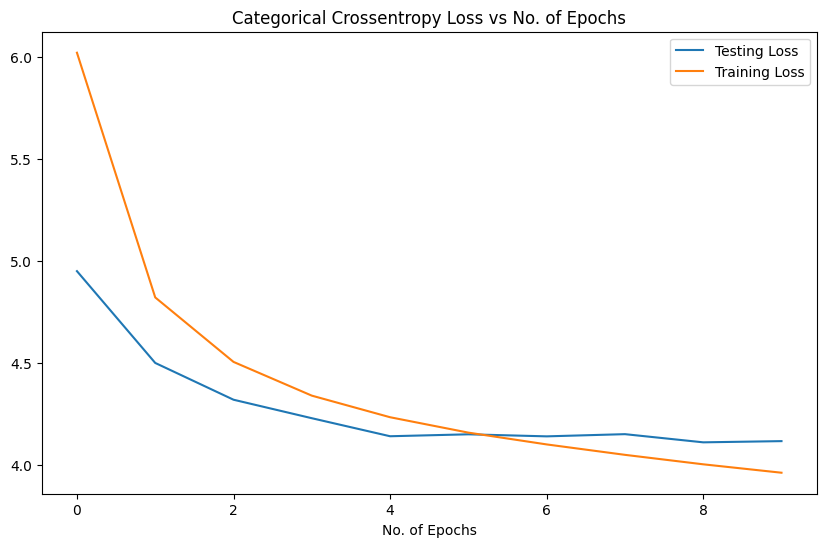

In [82]:
train_loss_values = []
test_loss_values = []
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    val_loss.reset_states()
    #training set - forward prop, loss fn, (gradient descent and optimization) backprop
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        # 85k samples
        # we display 3 batch results -- 0th, middle and last one (approx)
        # 85k / 64 ~ 1328; 1328 / 2 ~ 664
        if batch % 2601 == 0:
            print ('Epoch {} ========> Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result().numpy()))
      
    if (epoch + 1) % 2 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    train_loss_values.append(train_loss.result().numpy())
    
    #test set - forward pass, loss fn (no backward pass)
    for (batch, (inp, tar)) in enumerate(test_dataset):
        val_step(inp, tar)

    test_loss_values.append(val_loss.result().numpy())
    
    print ('Epoch {}/{} ========> Training Loss {:.4f} Test/Validation Loss {:.4f}'.format(epoch + 1, EPOCHS, train_loss.result().numpy(), val_loss.result().numpy()))
    
    print ('Time taken for epoch {}: {:.2f} secs\n'.format(epoch+1, time.time() - start))
no_of_epochs = [i for i in range(EPOCHS)]
fig , ax = plt.subplots(1,1)
fig.set_size_inches(10,6)
ax.plot(no_of_epochs, test_loss_values, label = 'Testing Loss')
ax.plot(no_of_epochs, train_loss_values, label = 'Training Loss')
ax.set_title('Categorical Crossentropy Loss vs No. of Epochs')
ax.legend()
ax.set_xlabel("No. of Epochs")
plt.show()

In [83]:
with open(default_path+'text_tokenizer.pickle', 'rb') as handle:
    text_tokenizer = pickle.load(handle)
with open(default_path+'summary_tokenizer.pickle', 'rb') as handle:
    summary_tokenizer = pickle.load(handle)
max_text_len = 300
max_summary_len = 16 

In [84]:
def predict(input_document):
    # #clean
    #input_document = preprocess_tokenize(input_document)
    input_document = "sostok "+input_document+" eostok"
    #tokenize
    input_document = text_tokenizer.texts_to_sequences([input_document])
    #padding
    input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=max_text_len, padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_document[0], 0)

    decoder_input = [summary_tokenizer.word_index["sostok"]]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(max_summary_len):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask,
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == summary_tokenizer.word_index["eostok"]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weightsdef summarize(input_document):
    # not considering attention weights for now, can be used to plot attention heatmaps in the future
    summarized = predict(input_document=input_document)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  # not printing <go> token
    return summary_tokenizer.sequences_to_texts(summarized)[0]  # since there is just one translated document
summarize("यूपी के लाल हैं कोविंद, दलित विरोधी हैं मायावतीः केशव मौर्या")

SyntaxError: invalid syntax (2505019680.py, line 35)

In [ ]:
documents = test["article"]
summary = test["headline"]samples = [17, 35, 69, 21, 26]
docs = []
summ = []
pred = []
for i in samples:
  pred.append(summarize(documents[i]))
  docs.append(' '.join(documents[i].split(' ')[:100]))
  summ.append(summary[i])


result_df = pd.DataFrame({'Input': docs, 'Reference Summary': summ, 'Model Output Summary': pred, 'Padding':pred })
result_df[['Input', 'Reference Summary', 'Model Output Summary']] #17, 69, 21, 26, 35
result_df.style.set_properties(subset=['Input', 'Padding'], **{'width': '400px'})

In [ ]:
from rouge import Roug

In [ ]:
rouge = Rouge()

In [ ]:
summary = result_df['Model Output Summary'][0]
reference = result_df['Reference Summary'][0]

In [ ]:
rouge.get_scores(summary,reference)